In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [ ]:
from google.colab import drive
import os

# Mount Google Drive (you'll need to authorize this)
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# mnist dataset
mnist_train = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 3.87MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.80MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.15MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# hyperparameters throughout the implementation
batch_size = 32
learning_rate = 1e-3
num_epoches = 5

In [ ]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        self.similarity = nn.CosineSimilarity(dim=-1, eps=1e-7)

    def forward(self, first, second, distance):
        # use cosine similarity from torch to get score
        score = self.similarity(first, second)
        # after cosine apply MSE between distance and score
        return nn.MSELoss()(score, distance)

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1), # 28 * 28 -> 28 * 28
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2), # 28 * 28 -> 14 * 14
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, 3, stride=1, padding=1), # 14 * 14 -> 14 * 14
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2), # 14 * 14 -> 7 * 7
            nn.Dropout(0.3),

            # nn.Conv2d(64, 64, 3, stride=1, padding=1), # 7 * 7 -> 7 * 7
            # nn.BatchNorm2d(64),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2), # 7 * 7 -> 3 * 3
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)
        )

        self.linear = nn.Sequential(
            nn.Linear(128 * 3 * 3, 512),
            nn.Tanh(),
            nn.Dropout(0.3),
            nn.Linear(512, 64),
            nn.Tanh()
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3, stride=2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 4, stride=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 3, stride=2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    def decode(self, z):
        z = z.view(z.size(0), 64, 1, 1)
        return self.decoder(z)

    def forward(self, x):
        lsr = self.encode(x)
        return self.decode(lsr), lsr

    def __call__(self, x):
        return self.forward(x)

In [ ]:
# define model
model = AutoEncoder()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
import random

def generate_pairs(data, labels, batch_size):
    pairs = []
    pair_labels = []

    for _ in range(batch_size):
        idx1 = random.randint(0, len(data) - 1)
        # With 50% probability, choose a similar or dissimilar pair
        if random.random() < 0.5:
            # Similar pair (same class)
            idx2 = random.choice((labels == labels[idx1]).nonzero(as_tuple=True)[0].tolist())
            pair_labels.append(1.0)  # 1 means similar
        else:
            # Dissimilar pair (different class)
            idx2 = random.choice((labels != labels[idx1]).nonzero(as_tuple=True)[0].tolist())
            pair_labels.append(0.0)  # 0 means dissimilar

        pairs.append((data[idx1], data[idx2]))

    return pairs, torch.tensor(pair_labels).float()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss functions
loss_func = nn.MSELoss()
contrastive_loss_fn = ContrastiveLoss()

best_loss = float('inf')

for epoch in range(num_epoches):
    count_loss = 0
    contrastive_count_loss = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass through the autoencoder
        recon_batches, _ = model(data.to(device))

        # Generate pairs and compute contrastive loss
        pairs, pair_labels = generate_pairs(data, labels, batch_size)
        img1 = torch.stack([pair[0] for pair in pairs]).to(device)
        img2 = torch.stack([pair[1] for pair in pairs]).to(device)

        # Encode both images in the pair
        encoded_img1 = model.encode(img1)
        encoded_img2 = model.encode(img2)

        # Calculate contrastive loss
        con_loss = contrastive_loss_fn(encoded_img1, encoded_img2, pair_labels.to(device))

        base_loss = loss_func(recon_batches, data.to(device))
        # Total loss = reconstruction loss + contrastive loss
        loss = (base_loss / batch_size) + (con_loss / (batch_size * 5))

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Accumulate the losses
        count_loss += base_loss.item() * len(data)  # Multiply to get total per epoch
        contrastive_count_loss += con_loss.item() * len(data)

        # Print loss every 100 batches
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch+1} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tBaseLoss: {loss.item():.6f}, ConLoss: {con_loss.item():.6f}')

    # Average loss for the epoch
    avg_loss = count_loss / len(train_loader.dataset)
    avg_contrastive_loss = contrastive_count_loss / len(train_loader.dataset)

    print('=======================================================================================\n',
        f'Epoch: {epoch+1} Average base loss: {avg_loss:.4f}, 'f'Average contrastive loss: {avg_contrastive_loss:.4f}\n',
          '=======================================================================================')

    # Save the best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), 'best_contrastive_autoencoder_leaky_sigmoid.pth')

# Save the final model
torch.save(model.state_dict(), 'final_contrastive_autoencoder_leaky_sigmoid.pth')

# Create save path in your Drive
save_path = '/content/drive/MyDrive/Colab Models/final_contrastive_autoencoder_leaky_sigmoid.pth'

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save model state dict
torch.save(model.state_dict(), save_path)

# Verify save
if os.path.exists(save_path):
    print(f"Model successfully saved to Google Drive: {save_path}")
else:
    print("Saving failed!")

Train Epoch: 1 [0/60000 (0%)]	BaseLoss: 0.011538, ConLoss: 0.194212
Train Epoch: 1 [3200/60000 (5%)]	BaseLoss: 0.003124, ConLoss: 0.107338
Train Epoch: 1 [6400/60000 (11%)]	BaseLoss: 0.002875, ConLoss: 0.152764
Train Epoch: 1 [9600/60000 (16%)]	BaseLoss: 0.002204, ConLoss: 0.076853
Train Epoch: 1 [12800/60000 (21%)]	BaseLoss: 0.002301, ConLoss: 0.081674
Train Epoch: 1 [16000/60000 (27%)]	BaseLoss: 0.001684, ConLoss: 0.054756
Train Epoch: 1 [19200/60000 (32%)]	BaseLoss: 0.001913, ConLoss: 0.077565
Train Epoch: 1 [22400/60000 (37%)]	BaseLoss: 0.001914, ConLoss: 0.099210
Train Epoch: 1 [25600/60000 (43%)]	BaseLoss: 0.001659, ConLoss: 0.093885
Train Epoch: 1 [28800/60000 (48%)]	BaseLoss: 0.001856, ConLoss: 0.123277
Train Epoch: 1 [32000/60000 (53%)]	BaseLoss: 0.001356, ConLoss: 0.054141
Train Epoch: 1 [35200/60000 (59%)]	BaseLoss: 0.001427, ConLoss: 0.051218
Train Epoch: 1 [38400/60000 (64%)]	BaseLoss: 0.001544, ConLoss: 0.086086
Train Epoch: 1 [41600/60000 (69%)]	BaseLoss: 0.001741, ConLo

In [ ]:
# Load the best model
model.load_state_dict(torch.load('final_contrastive_autoencoder_leaky_sigmoid.pth'))
model.eval()

<ipython-input-11-5c998e13f994>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('final_contrastive_autoencoder_leaky_sigmoid.pth'))


AutoEncoder(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0

In [ ]:
# Load the model
model = AutoEncoder()
model.load_state_dict(torch.load('/content/drive/MyDrive/final_contrastive_autoencoder_leaky_sigmoid.pth'))
model.eval()  # Set to evaluation mode

<ipython-input-10-3369940886a6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/final_contrastive_autoencoder_leaky

AutoEncoder(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0

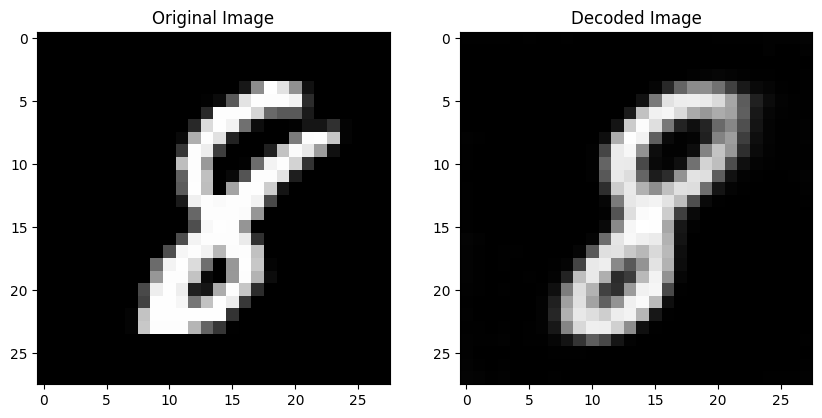

In [ ]:
# test decoder
devic = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
model.to(devic)

random_data = []
i = 0
for data, label in mnist_train:
    i += 1
    random_data.append(data)
    if i == 1000:
        break
random_data = torch.stack(random_data)

# one_data = []
# i = 0
# for data, label in mnist_train:
#     if label == 1:
#         i += 1
#         one_data.append(data)
#     if i == 1000:
#         break
# one_data = torch.stack(one_data)

one_embeded = model.encode(random_data)

decoded_one = model.decode(one_embeded)

i = random.randint(0, 1000)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


axs[0].imshow(random_data[i].squeeze(), cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(decoded_one[i].squeeze().detach().numpy(), cmap='gray')
axs[1].set_title('Decoded Image')
plt.show()

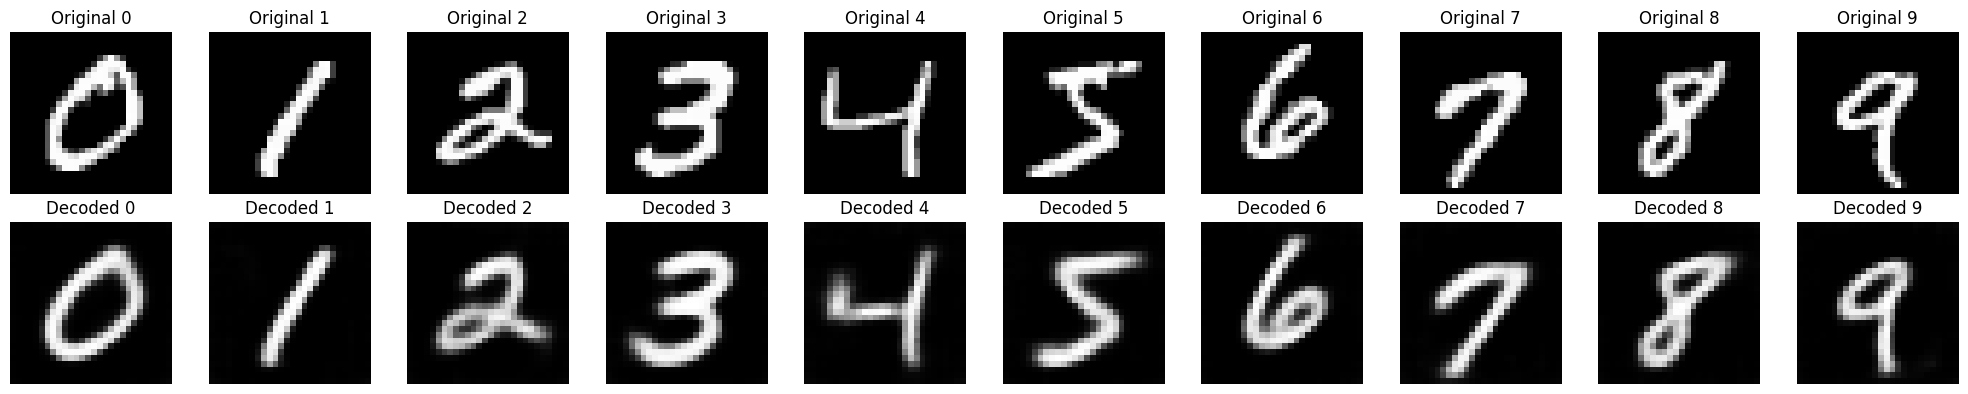

In [ ]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Collect one sample for each class (0-9)
class_samples = {}
for data, label in mnist_train:
    # Convert label tensor to Python integer
    label = label.item() if isinstance(label, torch.Tensor) else label

    # Only store first occurrence of each class
    if label not in class_samples:
        # Ensure data is in correct form (add channel dim if needed)
        if data.ndim == 2:
            data = data.unsqueeze(0)  # Add channel dimension
        class_samples[label] = data

    # Stop when we have all 10 classes
    if len(class_samples) == 10:
        break

# Verify we have all classes
assert len(class_samples) == 10, "Missing some classes in the samples!"

# Create ordered tensor batch (add batch dimension and move to device)
input_samples = torch.stack([class_samples[i] for i in range(10)]).to(device)

# Inference with gradient tracking disabled
with torch.no_grad():
    encoded = model.encode(input_samples)
    decoded = model.decode(encoded)

# Move outputs to CPU and convert to numpy for visualization
original_imgs = input_samples.cpu().numpy()
decoded_imgs = decoded.cpu().numpy()

# Create visualization
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for class_idx in range(10):
    # Original images (squeeze removes channel dim if needed)
    axs[0, class_idx].imshow(original_imgs[class_idx].squeeze(), cmap='gray')
    axs[0, class_idx].set_title(f'Original {class_idx}')
    axs[0, class_idx].axis('off')

    # Decoded images
    axs[1, class_idx].imshow(decoded_imgs[class_idx].squeeze(), cmap='gray')
    axs[1, class_idx].set_title(f'Decoded {class_idx}')
    axs[1, class_idx].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
model.to(device)
# Make a loop on the dataset to encode all images then give it to t-SNE
encoded_data = []
encoded_labels = []

for data, labels in train_loader:
    encoded_data.append(model.encode(data.to(device)).detach().cpu().numpy())
    encoded_labels.append(labels.cpu().numpy())  # Move labels to CPU and convert to numpy

# Concatenate the list of arrays into a single array
encoded_data = np.concatenate(encoded_data, axis=0)
encoded_labels = np.concatenate(encoded_labels, axis=0)  # Concatenate labels if needed

# Perform t-SNE on the encoded data
tsne = TSNE(n_components=2, random_state=0)
tsne_data = tsne.fit_transform(encoded_data)

# Plot the t-SNE data
plt.figure(figsize=(10, 10))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=encoded_labels, cmap='tab10', s=10)
plt.colorbar()
plt.title('t-SNE Visualization of Encoded Data')
plt.show()


NameError: name 'model' is not defined

In [ ]:
# generator from noise to embeded
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.linear = nn.Sequential(
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.linear(x)
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        x = F.sigmoid(x)
        return x

In [ ]:
class GAN(nn.Module):
    def __init__(self):
        super(GAN, self).__init__()
        self.generator = Generator()
        self.discriminator = Discriminator()

    def forward(self, x):
        x = self.generator(x)
        x = self.discriminator(x)
        return x

In [ ]:
# import torch
# import os
# model.to(device)
# real_vectors = []
# labels_list = []
# batch_size = 1000

# # Assume mnist_train is defined and is a DataLoader or similar iterable
# for i, (data, label) in enumerate(train_loader):
#     encoded_data = model.encode(data.to(device))
#     encoded_data = encoded_data.view(-1, 64)  # Assuming 128 is the dimension of the encoded vector

#     real_vectors.append(encoded_data)

#     # Make sure the label has an extra dimension before appending
#     labels_list.append(torch.tensor(label).unsqueeze(0).to(device))  # Add a dimension to the scalar label

#     # Save every batch_size vectors as a batch
#     if (i + 1) % batch_size == 0:
#         batch_tensor = torch.cat(real_vectors)
#         batch_labels = torch.cat(labels_list)  # Concatenate the labels now that they are 1D

#         torch.save((batch_tensor, batch_labels), f"encoded_data_batch_{i + 1}.pt")  # Save both data and labels
#         real_vectors = []  # Reset the list after saving
#         labels_list = []  # Reset the labels list after saving

# # Save the final batch if there are any remaining vectors
# if real_vectors:
#     batch_tensor = torch.cat(real_vectors)
#     batch_labels = torch.cat(labels_list)

#     torch.save((batch_tensor, batch_labels), "encoded_data_final.pt")  # Save both data and labels

# # Load all saved batches and combine them into one dataset
# combined_real_vectors = []
# combined_labels = []

# # Adjusted the range for loading batches
# for i in range(batch_size, 60000 + batch_size, batch_size):
#     batch_file = f"encoded_data_batch_{i}.pt"

#     if os.path.exists(batch_file):
#         batch_data, batch_labels = torch.load(batch_file)  # Load both data and labels
#         combined_real_vectors.append(batch_data)
#         combined_labels.append(batch_labels)

#         # After loading the batch, remove the file
#         os.remove(batch_file)

# # Load the final batch (if any) separately
# if os.path.exists("encoded_data_final.pt"):
#     final_batch_data, final_batch_labels = torch.load("encoded_data_final.pt")
#     combined_real_vectors.append(final_batch_data)
#     combined_labels.append(final_batch_labels)
#     os.remove("encoded_data_final.pt")

# # Concatenate all the batches to create the full dataset and labels
# full_dataset = torch.cat(combined_real_vectors)
# full_labels = torch.cat(combined_labels)

# # Save the full dataset and labels to disk
# torch.save((full_dataset, full_labels), "full_dataset_with_labels.pt")

# print(f"Total number of vectors: {full_dataset.shape[0]}")  # Should be 60,000
# print(f"Total number of labels: {full_labels.shape[0]}")  # Should also be 60,000



In [ ]:
import torch
import os

device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')

model.to(device)
real_vectors = []
real_labels = []
batch_size = 128

# Assume mnist_train is defined and is a DataLoader or similar iterable
for i, (data, label) in enumerate(train_loader):
    encoded_data = model.encode(data.to(device))
    encoded_data = encoded_data.view(-1, 64)  # Assuming 64 is the dimension of the encoded vector

    real_vectors.append(encoded_data)
    real_labels.append(label.to(device))  # Collect the corresponding labels

    # Save every batch_size vectors as a batch
    if (i + 1) % batch_size == 0:
        batch_tensor = torch.cat(real_vectors)
        batch_labels = torch.cat(real_labels)

        # Save both encoded data and labels
        torch.save((batch_tensor, batch_labels), f"encoded_data_batch_{i + 1}.pt")

        real_vectors = []  # Reset the list after saving
        real_labels = []   # Reset the label list

# Save the final batch if there are any remaining vectors
if real_vectors:
    batch_tensor = torch.cat(real_vectors)
    batch_labels = torch.cat(real_labels)

    torch.save((batch_tensor, batch_labels), "encoded_data_final.pt")  # Save both data and labels

# Load all saved batches and combine them into one dataset
combined_real_vectors = []
combined_real_labels = []

# Adjusted the range for loading batches
for i in range(batch_size, 60000 + batch_size, batch_size):
    batch_file = f"encoded_data_batch_{i}.pt"

    if os.path.exists(batch_file):
        batch_data, batch_labels = torch.load(batch_file)  # Load both data and labels
        combined_real_vectors.append(batch_data)
        combined_real_labels.append(batch_labels)

        # After loading the batch, remove the file
        os.remove(batch_file)

# Load the final batch (if any) separately
if os.path.exists("encoded_data_final.pt"):
    final_batch_data, final_batch_labels = torch.load("encoded_data_final.pt")
    combined_real_vectors.append(final_batch_data)
    combined_real_labels.append(final_batch_labels)

    os.remove("encoded_data_final.pt")

# Concatenate all the batches to create the full dataset and labels
full_dataset = torch.cat(combined_real_vectors)
full_labels = torch.cat(combined_real_labels)

# Save the full dataset and labels to disk
torch.save((full_dataset, full_labels), "full_dataset_with_labels.pt")

print(f"Total number of vectors: {full_dataset.shape[0]}")  # Should be 60,000
print(f"Total number of labels: {full_labels.shape[0]}")    # Should be 60,000


Total number of vectors: 60000
Total number of labels: 60000


<ipython-input-12-cea0c070d2a3>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch_data, batch_labels = torch.load(batch_file)  # Load both data and labels
<ipython-inp

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Load the full dataset and labels from the saved file
full_dataset, full_labels = torch.load("full_dataset_with_labels.pt")  # Unpack the dataset and labels

# Create a TensorDataset using the dataset (vectors) and the labels
real_vectors_dataset = TensorDataset(full_dataset, full_labels)


<ipython-input-13-2f145570e63c>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  full_dataset, full_labels = torch.load("full_dataset_with_labels.pt")  # Unpack the dataset 

In [ ]:
real_vectors_dataset[0]


(tensor([-1.0000, -0.9955,  0.9995, -1.0000, -0.9600,  0.5730,  0.9978,  0.1628,
          0.9848,  1.0000,  0.9724, -0.4642,  0.2747,  0.9973, -0.8869,  0.6551,
          0.8342,  0.5053,  0.8305,  0.1603, -0.9992, -0.9998, -1.0000,  0.3493,
         -0.8229, -0.7459, -0.9988,  0.9734, -0.9999,  1.0000,  0.4933, -0.9999,
         -1.0000,  0.9999,  0.2614,  0.6548,  0.7369, -0.6006,  0.9999, -0.9656,
          0.3013, -0.7916,  0.4360,  1.0000, -0.9076, -1.0000, -0.8189,  0.2583,
          0.3883,  0.6493, -0.9945, -0.8492,  1.0000, -0.5612,  0.4836,  0.2227,
         -0.6928, -0.2799, -0.6918, -0.7686, -0.8974,  1.0000, -0.9008,  0.8724],
        grad_fn=<SelectBackward0>),
 tensor(9))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 3e-4
z_dim = 32
batch_size = 32
num_epochs = 50

gan = GAN().to(device)
opt_disc = optim.Adam(gan.discriminator.parameters(), lr=lr)
opt_gen = optim.Adam(gan.generator.parameters(), lr=lr)
criterion = nn.BCELoss()


train_loader = DataLoader(real_vectors_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
counter = 0

# Modified training loop with correct unpacking
def train(num_of_epochs):
    global counter

    for epoch in range(num_of_epochs):
        counter += 1

        # Fix: Unpack both data and labels (even if labels aren't used)
        for batch_idx, (real_batch, _) in enumerate(train_loader):  # Added underscore for labels
            real = real_batch.view(-1, 64).to(device)
            batch_size = real.shape[0]

            # Generate noise
            noise = torch.randn(batch_size, z_dim).to(device)
            fake = gan.generator(noise)

            # Discriminator loss
            lossD = train_discriminator(real, fake)

            # Generator loss
            lossG = train_generator(fake)

            # Logging progress
            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch + 1}/{num_of_epochs}], Batch [{batch_idx}/{len(train_loader)}] | Loss D: {lossD:.4f}, Loss G: {lossG:.4f}")

        print("=====================================================================")
        print(f"Epoch [{counter}/{num_of_epochs}] | Loss D: {lossD:.4f}, Loss G: {lossG:.4f}")
        print("=====================================================================")

def train_discriminator(real, fake):
    # Discriminator loss for real data
    disc_real = gan.discriminator(real).view(-1)
    lossD_real = criterion(disc_real, torch.ones_like(disc_real))

    # Discriminator loss for fake data
    disc_fake = gan.discriminator(fake).view(-1)
    lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

    # Total discriminator loss
    lossD = (lossD_real + lossD_fake) / 2
    gan.discriminator.zero_grad()
    lossD.backward(retain_graph=True)

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(gan.discriminator.parameters(), max_norm=1.0)
    opt_disc.step()

    return lossD.item()

def train_generator(fake):
    output = gan.discriminator(fake).view(-1)
    lossG = criterion(output, torch.ones_like(output))
    gan.zero_grad()
    lossG.backward()
    opt_gen.step()

    return lossG.item()


In [ ]:
train(5)

Epoch [1/5], Batch [0/1875] | Loss D: 0.6936, Loss G: 0.6920
Epoch [1/5], Batch [100/1875] | Loss D: 0.4884, Loss G: 0.8314
Epoch [1/5], Batch [200/1875] | Loss D: 0.1342, Loss G: 2.0229
Epoch [1/5], Batch [300/1875] | Loss D: 0.0691, Loss G: 3.1315
Epoch [1/5], Batch [400/1875] | Loss D: 0.0652, Loss G: 3.7987
Epoch [1/5], Batch [500/1875] | Loss D: 0.0718, Loss G: 3.8181
Epoch [1/5], Batch [600/1875] | Loss D: 0.0339, Loss G: 4.1221
Epoch [1/5], Batch [700/1875] | Loss D: 0.0521, Loss G: 3.9815
Epoch [1/5], Batch [800/1875] | Loss D: 0.0547, Loss G: 4.5027
Epoch [1/5], Batch [900/1875] | Loss D: 0.1387, Loss G: 3.6037
Epoch [1/5], Batch [1000/1875] | Loss D: 0.4012, Loss G: 3.3504
Epoch [1/5], Batch [1100/1875] | Loss D: 0.1397, Loss G: 4.1158
Epoch [1/5], Batch [1200/1875] | Loss D: 0.1500, Loss G: 3.0667
Epoch [1/5], Batch [1300/1875] | Loss D: 0.3335, Loss G: 2.9768
Epoch [1/5], Batch [1400/1875] | Loss D: 0.2660, Loss G: 3.1680
Epoch [1/5], Batch [1500/1875] | Loss D: 0.2344, Los

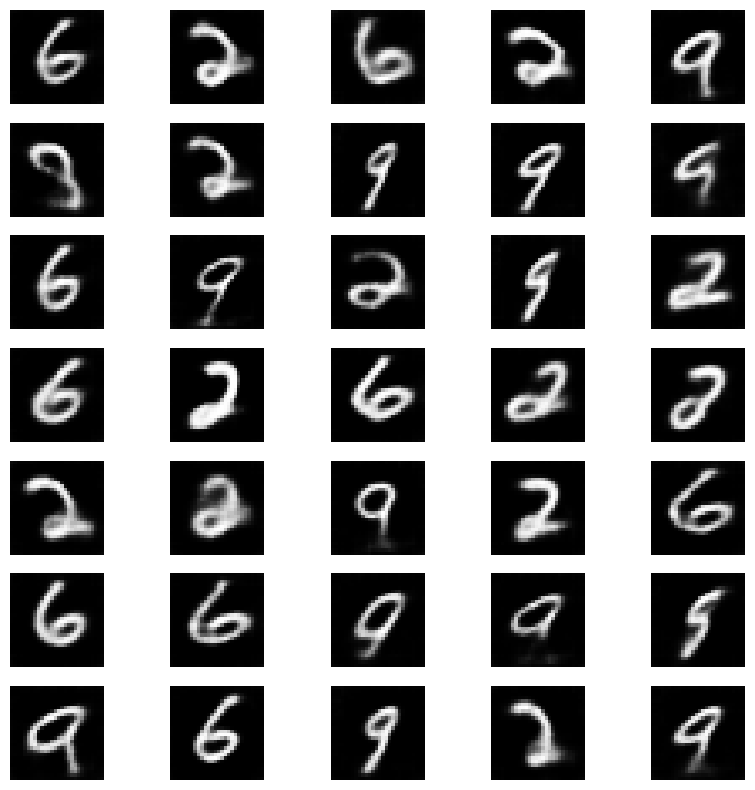

In [ ]:
def generate_and_decode(num_samples=10):
    # Set both the GAN and autoencoder to evaluation mode
    gan.eval()
    model.to('cuda')
    model.eval()


    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))  # Create a subplot for each sample

    for i in range(num_samples):
        # Generate a fake image (latent vector from GAN)
        noise = torch.randn(1, z_dim).to(device)  # Generate noise for 1 image

        with torch.no_grad():
            fake_image = gan.generator(noise)  # Generate fake latent representation

        # Reshape the latent vector to match the decoder input
        reshaped_fake_image = fake_image.view(1, 64, 1, 1)  # Correct (64 channels)

        # Decode the fake image using the autoencoder's decoder
        with torch.no_grad():
            decoded_image = model.decode(reshaped_fake_image)  # Decode the reshaped latent vector

        # Convert tensors to CPU and detach them for visualization
        fake_image = fake_image.cpu().detach().numpy().reshape(1, 64)  # Adjust the reshape if needed
        decoded_image = decoded_image.cpu().detach().numpy().reshape(28, 28)  # Adjust the reshape for MNIST

        # Plot the generated (fake) image
        axs[i, 0].imshow(fake_image, cmap='gray')
        axs[i, 0].set_title(f'Generated (Fake) Image {i+1}')

        # Plot the decoded image
        axs[i, 1].imshow(decoded_image, cmap='gray')
        axs[i, 1].set_title(f'Decoded Image {i+1}')

    # Show the plots
    plt.tight_layout()

    plt.show()


def test_generate(d):
    noise = torch.randn(d, z_dim).to(device)

    fake = gan.generator(noise)
    reshaped_fake_image = fake.view(d, 64, 1, 1)
    decoded_image = model.decode(reshaped_fake_image)
    decoded_image = decoded_image.cpu().detach().numpy()
    plt.figure(figsize=(10, 10))
    for i in range(d):
        plt.subplot(7, 5, i+1)
        plt.imshow(decoded_image[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()


# Run the function to generate and decode 10 images
test_generate(35)


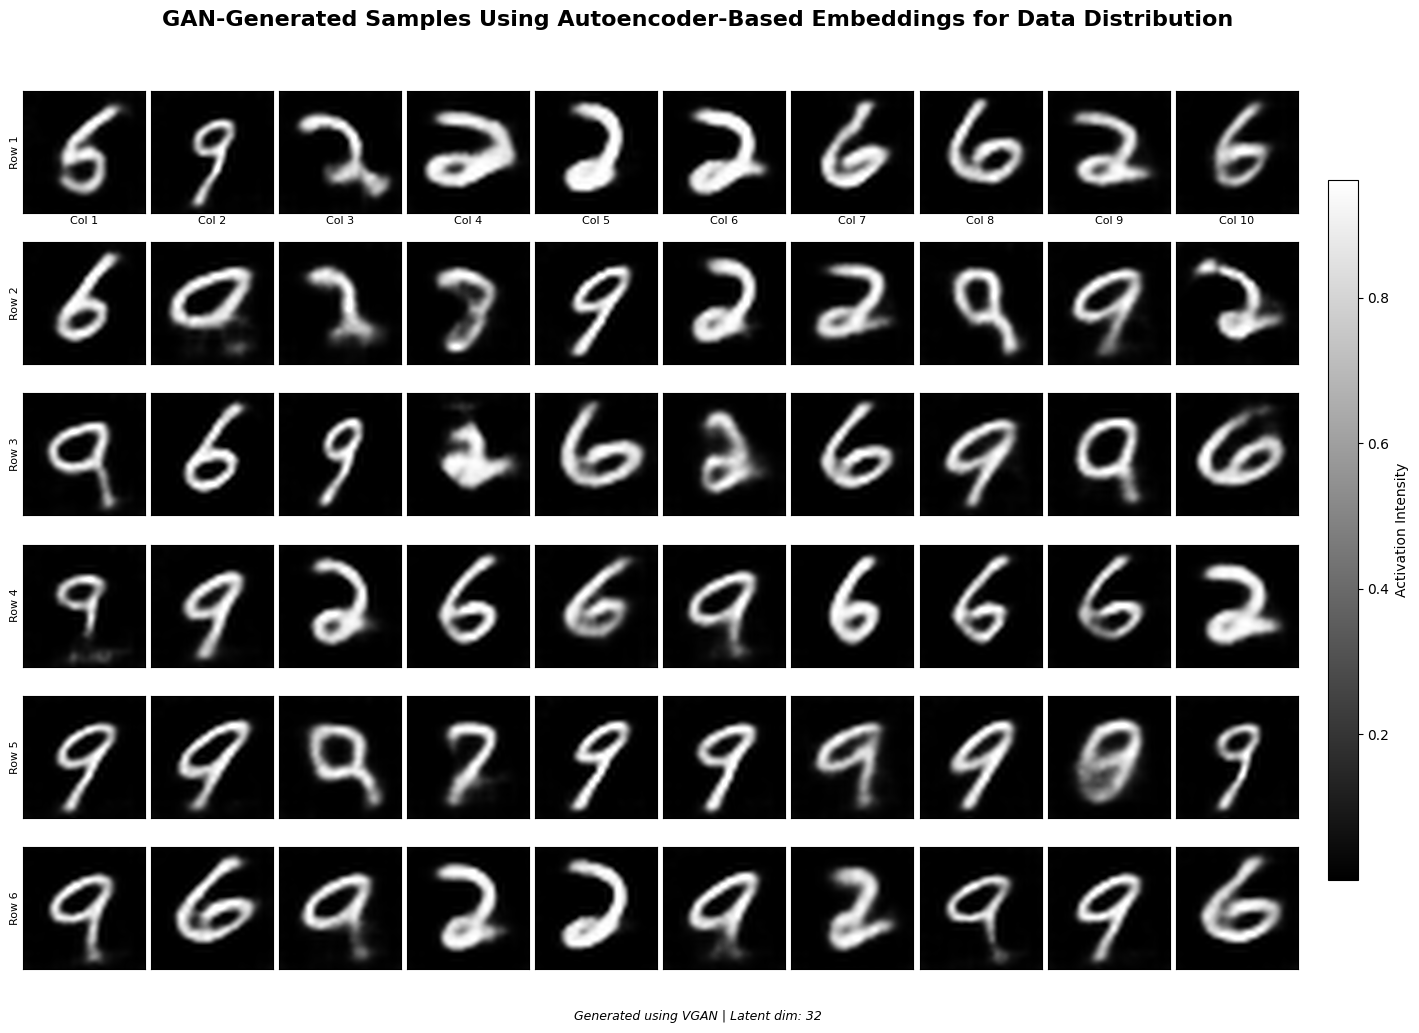

In [ ]:
def test_generate(d):
    # Generate latent vectors and labels
    noise = torch.randn(d, z_dim).to(device)
    random_labels = torch.cat([torch.arange(10) for _ in range(d//10)]).long().to(device)

    # Generate images
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode
        fake = gan.generator(noise)
        reshaped_fake = fake.view(d, 64, 1, 1)
        decoded_images = model.decode(reshaped_fake).cpu().numpy()

    # Create figure with better layout
    fig = plt.figure(figsize=(15, 10), dpi=100)
    fig.suptitle('GAN-Generated Samples Using Autoencoder-Based Embeddings for Data Distribution',
                fontsize=16, y=1.02, fontweight='bold')

    # Calculate grid dimensions (6 rows x 10 columns)
    rows = 6
    cols = 10

    for i in range(d):
        ax = fig.add_subplot(rows, cols, i+1)

        # Display image with improved contrast
        img = decoded_images[i].reshape(28, 28)
        im = ax.imshow(img, cmap='gray', interpolation='lanczos',
                      vmin=img.min(), vmax=img.max())

        # # Add class label annotation
        # ax.text(0.05, 0.05, str(random_labels[i].item()),
        #         transform=ax.transAxes,
        #         color='white' if img.mean() < 0.5 else 'black',
        #         fontsize=8,
        #         fontweight='bold')

        # Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # Add column labels for first row
        if i < cols:
            ax.set_xlabel(f'Col {i+1}', fontsize=8, labelpad=2)

        # Add row labels for first column
        if i % cols == 0:
            ax.set_ylabel(f'Row {i//cols+1}', fontsize=8, labelpad=2)

    # Add colorbar
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cax, label='Activation Intensity')

    # Adjust layout and spacing
    plt.subplots_adjust(wspace=0.05, hspace=0.05,
                       left=0.05, right=0.9,
                       bottom=0.05, top=0.95)

    # Add footer text
    plt.figtext(0.5, 0.01,
               f'Generated using VGAN | Latent dim: {z_dim}',
               ha='center', fontsize=9, style='italic')

    plt.show()

# Generate and display 60 images (6 rows of 10 digits each)
test_generate(60)

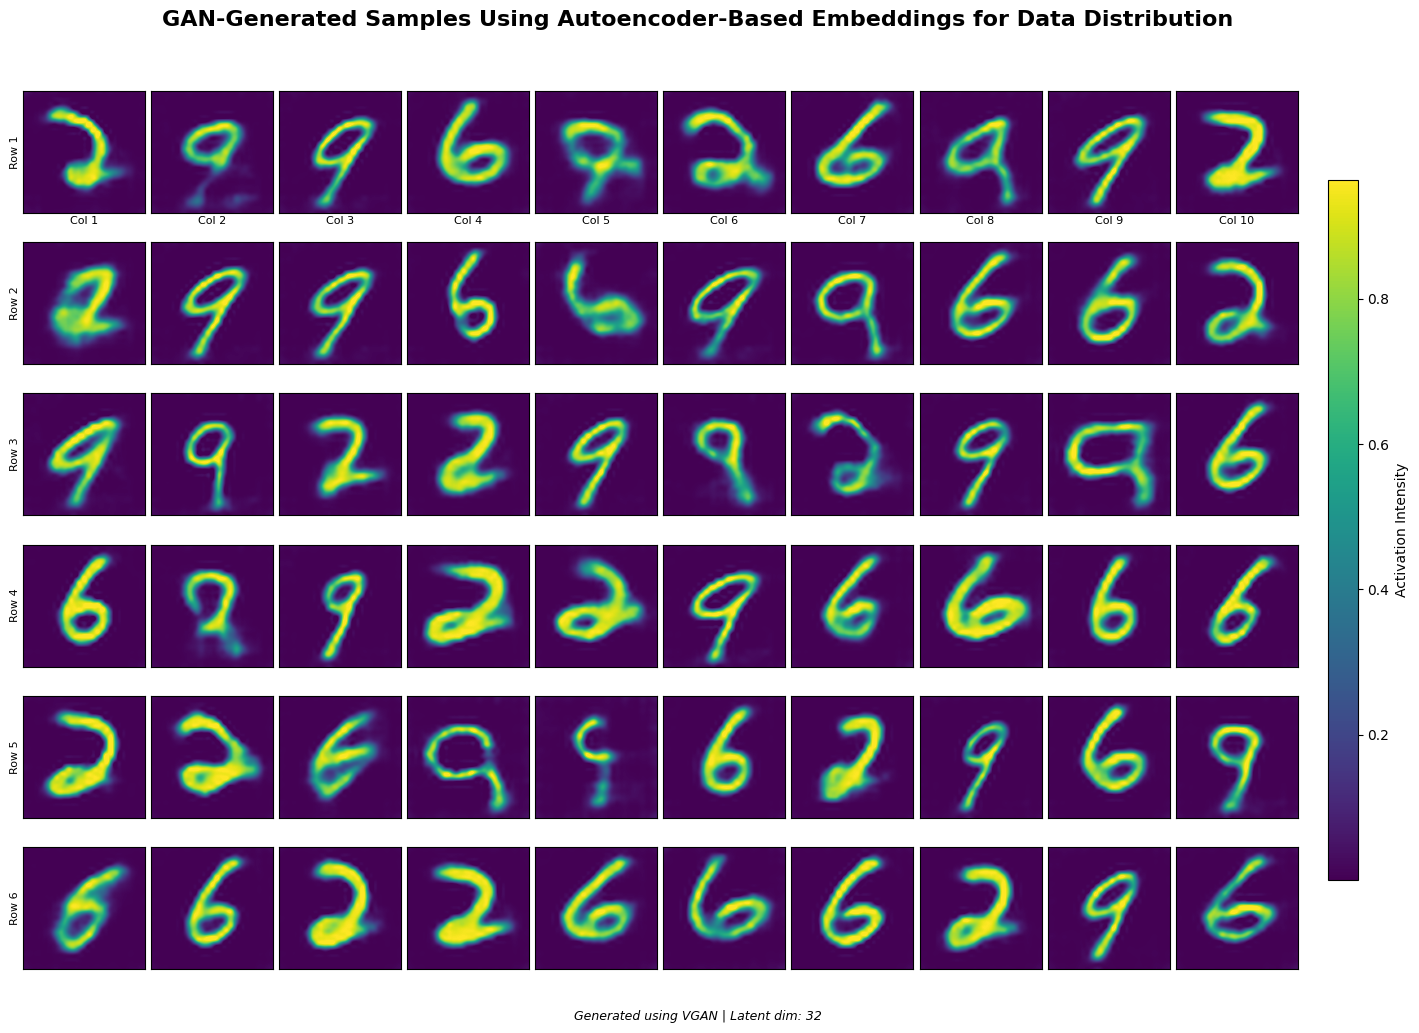

In [ ]:
def test_generate(d):
    # Generate latent vectors and labels
    noise = torch.randn(d, z_dim).to(device)
    random_labels = torch.cat([torch.arange(10) for _ in range(d//10)]).long().to(device)

    # Generate images
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode
        fake = gan.generator(noise)
        reshaped_fake = fake.view(d, 64, 1, 1)
        decoded_images = model.decode(reshaped_fake).cpu().numpy()

    # Create figure with better layout
    fig = plt.figure(figsize=(15, 10), dpi=100)
    fig.suptitle('GAN-Generated Samples Using Autoencoder-Based Embeddings for Data Distribution',
                fontsize=16, y=1.02, fontweight='bold')

    # Calculate grid dimensions (6 rows x 10 columns)
    rows = 6
    cols = 10

    for i in range(d):
        ax = fig.add_subplot(rows, cols, i+1)

        # Display image with improved contrast
        img = decoded_images[i].reshape(28, 28)
        im = ax.imshow(img, cmap='viridis', interpolation='lanczos',
                      vmin=img.min(), vmax=img.max())

        # # Add class label annotation
        # ax.text(0.05, 0.05, str(random_labels[i].item()),
        #         transform=ax.transAxes,
        #         color='white' if img.mean() < 0.5 else 'black',
        #         fontsize=8,
        #         fontweight='bold')

        # Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # Add column labels for first row
        if i < cols:
            ax.set_xlabel(f'Col {i+1}', fontsize=8, labelpad=2)

        # Add row labels for first column
        if i % cols == 0:
            ax.set_ylabel(f'Row {i//cols+1}', fontsize=8, labelpad=2)

    # Add colorbar
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cax, label='Activation Intensity')

    # Adjust layout and spacing
    plt.subplots_adjust(wspace=0.05, hspace=0.05,
                       left=0.05, right=0.9,
                       bottom=0.05, top=0.95)

    # Add footer text
    plt.figtext(0.5, 0.01,
               f'Generated using VGAN | Latent dim: {z_dim}',
               ha='center', fontsize=9, style='italic')

    plt.show()

# Generate and display 60 images (6 rows of 10 digits each)
test_generate(60)

In [ ]:
class ACGAN_Generator(nn.Module):
    def __init__(self, num_classes):
        super(ACGAN_Generator, self).__init__()

        # Linear layers
        self.label_embedding = nn.Embedding(num_classes, 32)  # Embedding for class labels

        self.linear = nn.Sequential(
            nn.Linear(32 + 32, 64),   # Concatenate latent vector and class embedding
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embeds = self.label_embedding(labels)  # Embed class labels
        x = torch.cat([noise, label_embeds], dim=1)  # Concatenate noise and labels
        x = self.linear(x)
        return x


In [ ]:
class ACGAN_Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(ACGAN_Discriminator, self).__init__()

        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)

        # Output for real/fake
        self.fc4_real_fake = nn.Linear(32, 1)

        # Output for class label prediction
        self.fc4_aux_class = nn.Linear(32, num_classes)  # Number of classes for classification

    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)

        # Two outputs: real/fake and class prediction
        real_fake = F.sigmoid(self.fc4_real_fake(x))  # Real/fake output
        aux_class = self.fc4_aux_class(x)             # Class label output (logits)

        return real_fake, aux_class


In [ ]:
class ACGAN(nn.Module):
    def __init__(self, num_classes):
        super(ACGAN, self).__init__()
        self.generator = ACGAN_Generator(num_classes)
        self.discriminator = ACGAN_Discriminator(num_classes)

    def forward(self, noise, labels):
        generated_data = self.generator(noise, labels)
        real_fake, aux_class = self.discriminator(generated_data)
        return real_fake, aux_class


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 3e-4  # learning rate
z_dim = 32  # dimension of latent space
batch_size = 32
num_epochs = 50
clip_value = 1.0  # For gradient clipping

# Define GAN
gan = ACGAN(num_classes=10).to(device)  # assuming 10 classes for ACGAN
opt_disc = optim.Adam(gan.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_gen = optim.Adam(gan.generator.parameters(), lr=lr, betas=(0.5, 0.999))

# Use learning rate schedulers for both optimizers
scheduler_disc = torch.optim.lr_scheduler.StepLR(opt_disc, step_size=10, gamma=0.5)
scheduler_gen = torch.optim.lr_scheduler.StepLR(opt_gen, step_size=10, gamma=0.5)

criterion = nn.BCELoss()  # Binary Cross-Entropy loss for real/fake classification

train_loader = DataLoader(real_vectors_dataset, batch_size=batch_size, shuffle=True)

counter = 0

def train_ac(num_of_epochs):
    global counter

    for epoch in range(num_of_epochs):
        counter += 1

        for batch_idx, (real_batch, labels) in enumerate(train_loader):
            real = real_batch.view(-1, 64).to(device)  # Adjust dimensions as needed
            labels = labels.to(device)
            batch_size = real.shape[0]

            # Generate noise and random labels for fake data
            noise = torch.randn(batch_size, z_dim).to(device)
            random_labels = torch.randint(0, 10, (batch_size,)).to(device)  # assuming 10 classes
            fake = gan.generator(noise, random_labels)

            # Discriminator loss
            lossD = train_discriminator(real, fake, labels, random_labels)

            # Generator loss
            lossG = train_generator(fake, random_labels)

            # Logging progress every 100 batches
            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch + 1}/{num_of_epochs}], Batch [{batch_idx}/{len(train_loader)}] | Loss D: {lossD:.10f}, Loss G: {lossG:.10f}")

        # Step the learning rate schedulers
        scheduler_disc.step()
        scheduler_gen.step()

        print("=====================================================================================")
        print(f"Epoch [{counter}/{num_of_epochs}] | Loss D: {lossD:.10f}, Loss G: {lossG:.10f}")
        print("=====================================================================================")

def train_discriminator(real, fake, real_labels, fake_labels):
    # Real data discriminator loss
    disc_real, real_class_preds = gan.discriminator(real)
    lossD_real = criterion(disc_real, torch.ones_like(disc_real).to(device))  # Real data loss
    loss_class_real = F.cross_entropy(real_class_preds, real_labels)  # Real class label loss

    # Fake data discriminator loss
    disc_fake, fake_class_preds = gan.discriminator(fake.detach())  # detach so that generator gradients are not computed here
    lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake).to(device))  # Fake data loss

    # Total loss for discriminator
    lossD = (lossD_real + lossD_fake) / 2 + loss_class_real
    gan.discriminator.zero_grad()
    lossD.backward(retain_graph=True)

    # Clip gradients to stabilize training
    torch.nn.utils.clip_grad_norm_(gan.discriminator.parameters(), max_norm=clip_value)
    opt_disc.step()

    return lossD.item()

def train_generator(fake, fake_labels):
    # Generator is trying to fool the discriminator into thinking generated data is real
    disc_fake, fake_class_preds = gan.discriminator(fake)
    lossG_fake = criterion(disc_fake, torch.ones_like(disc_fake).to(device))  # Should be classified as real

    # Class label loss for the generated data
    loss_class_fake = F.cross_entropy(fake_class_preds, fake_labels)

    # Total generator loss
    lossG = lossG_fake + loss_class_fake
    gan.generator.zero_grad()
    lossG.backward()
    opt_gen.step()

    return lossG.item()


In [ ]:
train_ac(5)

Epoch [1/5], Batch [0/1875] | Loss D: 3.0298812389, Loss G: 2.8931665421
Epoch [1/5], Batch [100/1875] | Loss D: 1.2187025547, Loss G: 1.8775744438
Epoch [1/5], Batch [200/1875] | Loss D: 0.7653644085, Loss G: 0.9463521242
Epoch [1/5], Batch [300/1875] | Loss D: 0.6191067696, Loss G: 0.8119637370
Epoch [1/5], Batch [400/1875] | Loss D: 0.6585041285, Loss G: 0.7580854893
Epoch [1/5], Batch [500/1875] | Loss D: 0.6630941033, Loss G: 0.7951762080
Epoch [1/5], Batch [600/1875] | Loss D: 0.8472187519, Loss G: 0.6779602766
Epoch [1/5], Batch [700/1875] | Loss D: 0.6777799129, Loss G: 0.7134424448
Epoch [1/5], Batch [800/1875] | Loss D: 0.7495775223, Loss G: 0.6879417896
Epoch [1/5], Batch [900/1875] | Loss D: 0.6643280983, Loss G: 0.7202833891
Epoch [1/5], Batch [1000/1875] | Loss D: 0.8281476498, Loss G: 0.7340482473
Epoch [1/5], Batch [1100/1875] | Loss D: 0.6752369404, Loss G: 0.7661548257
Epoch [1/5], Batch [1200/1875] | Loss D: 0.6833795309, Loss G: 0.7212896347
Epoch [1/5], Batch [1300

In [ ]:
!pip install Optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.2 MB/s eta 0:00:00


In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def objective(trial):
    # Hyperparameters to optimize
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [1, 5, 15])
    clip_value = trial.suggest_float('clip_value', 0.5, 2.0)
    z_dim = 32

    # Define GAN
    gan = ACGAN(num_classes=10).to(device)
    opt_disc = optim.Adam(gan.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_gen = optim.Adam(gan.generator.parameters(), lr=lr, betas=(0.5, 0.999))

    # Use learning rate schedulers for both optimizers
    scheduler_disc = torch.optim.lr_scheduler.StepLR(opt_disc, step_size=10, gamma=0.5)
    scheduler_gen = torch.optim.lr_scheduler.StepLR(opt_gen, step_size=10, gamma=0.5)

    criterion = nn.BCELoss()

    train_loader = DataLoader(real_vectors_dataset, batch_size=batch_size, shuffle=True)

    def train_ac(num_of_epochs):
        final_lossG = None  # Track the final generator loss
        for epoch in range(num_of_epochs):
            for batch_idx, (real_batch, labels) in enumerate(train_loader):
                real = real_batch.view(-1, 64).to(device)
                labels = labels.to(device)
                batch_size = real.shape[0]

                noise = torch.randn(batch_size, z_dim).to(device)
                random_labels = torch.randint(0, 10, (batch_size,)).to(device)
                fake = gan.generator(noise, random_labels)

                lossD = train_discriminator(real, fake, labels, random_labels)
                lossG = train_generator(fake, random_labels)

                # Update final_lossG with the last batch's value
                final_lossG = lossG

                if batch_idx % 100 == 0:
                    print(f"Epoch [{epoch + 1}/{num_of_epochs}], Batch [{batch_idx}/{len(train_loader)}] | Loss D: {lossD:.10f}, Loss G: {lossG:.10f}")

            scheduler_disc.step()
            scheduler_gen.step()

            print("=====================================================================================")
            print(f"Epoch [{epoch + 1}/{num_of_epochs}] | Loss D: {lossD:.10f}, Loss G: {lossG:.10f}")
            print("=====================================================================================")

        return final_lossG  # Return the final generator loss

    def train_discriminator(real, fake, real_labels, fake_labels):
        disc_real, real_class_preds = gan.discriminator(real)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real).to(device))
        loss_class_real = F.cross_entropy(real_class_preds, real_labels)

        disc_fake, fake_class_preds = gan.discriminator(fake.detach())
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake).to(device))

        lossD = (lossD_real + lossD_fake) / 2 + loss_class_real
        gan.discriminator.zero_grad()
        lossD.backward(retain_graph=True)

        torch.nn.utils.clip_grad_norm_(gan.discriminator.parameters(), max_norm=clip_value)
        opt_disc.step()

        return lossD.item()

    def train_generator(fake, fake_labels):
        disc_fake, fake_class_preds = gan.discriminator(fake)
        lossG_fake = criterion(disc_fake, torch.ones_like(disc_fake).to(device))
        loss_class_fake = F.cross_entropy(fake_class_preds, fake_labels)

        lossG = lossG_fake + loss_class_fake
        gan.generator.zero_grad()
        lossG.backward()
        opt_gen.step()

        return lossG.item()

    # Train the model and capture the final generator loss
    final_generator_loss = train_ac(num_epochs)
    return final_generator_loss  # Return the final generator loss for optimization

In [ ]:
study = optuna.create_study(direction='minimize')  # Minimize the generator loss
study.optimize(objective, n_trials=50)  # Number of trials

# Print the best hyperparameters
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-02-28 15:25:42,226] A new study created in memory with name: no-name-b6ee95bb-3bdb-47db-8d90-2563bd48c825


Epoch [1/5], Batch [0/1875] | Loss D: 3.0361220837, Loss G: 2.8943011761
Epoch [1/5], Batch [100/1875] | Loss D: 2.9948883057, Loss G: 2.9237318039
Epoch [1/5], Batch [200/1875] | Loss D: 2.9550547600, Loss G: 2.9204425812
Epoch [1/5], Batch [300/1875] | Loss D: 2.9391195774, Loss G: 2.9079601765
Epoch [1/5], Batch [400/1875] | Loss D: 2.9804930687, Loss G: 2.8867039680
Epoch [1/5], Batch [500/1875] | Loss D: 2.8601193428, Loss G: 2.9096527100
Epoch [1/5], Batch [600/1875] | Loss D: 2.8447723389, Loss G: 2.9077272415
Epoch [1/5], Batch [700/1875] | Loss D: 2.8145740032, Loss G: 2.9048655033
Epoch [1/5], Batch [800/1875] | Loss D: 2.7435891628, Loss G: 2.8726830482
Epoch [1/5], Batch [900/1875] | Loss D: 2.6851420403, Loss G: 2.8552541733
Epoch [1/5], Batch [1000/1875] | Loss D: 2.6072390079, Loss G: 2.7982823849
Epoch [1/5], Batch [1100/1875] | Loss D: 2.5534341335, Loss G: 2.8062539101
Epoch [1/5], Batch [1200/1875] | Loss D: 2.4770734310, Loss G: 2.7422518730
Epoch [1/5], Batch [1300

[I 2025-02-28 15:41:34,028] Trial 0 finished with value: 0.7530670166015625 and parameters: {'lr': 1.1985644625673143e-05, 'batch_size': 32, 'num_epochs': 5, 'clip_value': 1.3906170967508371}. Best is trial 0 with value: 0.7530670166015625.


Epoch [5/5] | Loss D: 0.6349810362, Loss G: 0.7530670166
Epoch [1/15], Batch [0/938] | Loss D: 3.0198612213, Loss G: 3.0282232761
Epoch [1/15], Batch [100/938] | Loss D: 2.9652566910, Loss G: 2.9968569279
Epoch [1/15], Batch [200/938] | Loss D: 2.8811213970, Loss G: 3.0033855438
Epoch [1/15], Batch [300/938] | Loss D: 2.8155651093, Loss G: 2.9822292328
Epoch [1/15], Batch [400/938] | Loss D: 2.7101144791, Loss G: 2.9710328579
Epoch [1/15], Batch [500/938] | Loss D: 2.4706544876, Loss G: 2.8731546402
Epoch [1/15], Batch [600/938] | Loss D: 2.2731153965, Loss G: 2.7408428192
Epoch [1/15], Batch [700/938] | Loss D: 2.0404908657, Loss G: 2.5134358406
Epoch [1/15], Batch [800/938] | Loss D: 1.9956262112, Loss G: 2.2890658379
Epoch [1/15], Batch [900/938] | Loss D: 1.7551627159, Loss G: 2.1150636673
Epoch [1/15] | Loss D: 1.4604890347, Loss G: 2.0282554626
Epoch [2/15], Batch [0/938] | Loss D: 1.7074102163, Loss G: 2.0464510918
Epoch [2/15], Batch [100/938] | Loss D: 1.4761385918, Loss G: 1.

[I 2025-02-28 16:25:46,991] Trial 1 finished with value: 0.7028453946113586 and parameters: {'lr': 2.4072559337961916e-05, 'batch_size': 64, 'num_epochs': 15, 'clip_value': 1.3149131104708576}. Best is trial 1 with value: 0.7028453946113586.


Epoch [15/15] | Loss D: 0.7519378066, Loss G: 0.7028453946
Epoch [1/5], Batch [0/469] | Loss D: 3.0010957718, Loss G: 2.9958376884
Epoch [1/5], Batch [100/469] | Loss D: 2.9769248962, Loss G: 2.9938969612
Epoch [1/5], Batch [200/469] | Loss D: 2.9312806129, Loss G: 2.9925913811
Epoch [1/5], Batch [300/469] | Loss D: 2.8763003349, Loss G: 2.9709172249
Epoch [1/5], Batch [400/469] | Loss D: 2.7735266685, Loss G: 2.9549160004
Epoch [1/5] | Loss D: 2.7493419647, Loss G: 2.9055976868
Epoch [2/5], Batch [0/469] | Loss D: 2.7388596535, Loss G: 2.9157907963
Epoch [2/5], Batch [100/469] | Loss D: 2.6091539860, Loss G: 2.8520526886
Epoch [2/5], Batch [200/469] | Loss D: 2.4323287010, Loss G: 2.7489771843
Epoch [2/5], Batch [300/469] | Loss D: 2.2661368847, Loss G: 2.6342940331
Epoch [2/5], Batch [400/469] | Loss D: 2.0420064926, Loss G: 2.4467713833
Epoch [2/5] | Loss D: 1.9950501919, Loss G: 2.3290314674
Epoch [3/5], Batch [0/469] | Loss D: 2.0129733086, Loss G: 2.3761715889
Epoch [3/5], Batch 

[I 2025-02-28 16:40:17,295] Trial 2 finished with value: 0.9387106895446777 and parameters: {'lr': 2.0094791880131784e-05, 'batch_size': 128, 'num_epochs': 5, 'clip_value': 1.7308679830042406}. Best is trial 1 with value: 0.7028453946113586.


Epoch [5/5] | Loss D: 0.7610399127, Loss G: 0.9387106895
Epoch [1/5], Batch [0/469] | Loss D: 2.9869484901, Loss G: 3.0206944942
Epoch [1/5], Batch [100/469] | Loss D: 2.7527027130, Loss G: 2.9391648769
Epoch [1/5], Batch [200/469] | Loss D: 2.1162223816, Loss G: 2.4669172764
Epoch [1/5], Batch [300/469] | Loss D: 1.3196275234, Loss G: 1.7934403419
Epoch [1/5], Batch [400/469] | Loss D: 0.9130294323, Loss G: 1.2350863218
Epoch [1/5] | Loss D: 0.7481545210, Loss G: 0.9899317026
Epoch [2/5], Batch [0/469] | Loss D: 0.7536652088, Loss G: 1.0378521681
Epoch [2/5], Batch [100/469] | Loss D: 0.7234190106, Loss G: 0.8884912133
Epoch [2/5], Batch [200/469] | Loss D: 0.6507031918, Loss G: 0.8228119612
Epoch [2/5], Batch [300/469] | Loss D: 0.6513301134, Loss G: 0.7696411610
Epoch [2/5], Batch [400/469] | Loss D: 0.6793110371, Loss G: 0.7356423140
Epoch [2/5] | Loss D: 0.6784546971, Loss G: 0.7273663878
Epoch [3/5], Batch [0/469] | Loss D: 0.6627730727, Loss G: 0.7329035997
Epoch [3/5], Batch [1

[I 2025-02-28 16:54:22,909] Trial 3 finished with value: 0.6976242065429688 and parameters: {'lr': 8.320648456238318e-05, 'batch_size': 128, 'num_epochs': 5, 'clip_value': 1.2759185931047614}. Best is trial 3 with value: 0.6976242065429688.


Epoch [5/5] | Loss D: 0.6883192062, Loss G: 0.6976242065
Epoch [1/15], Batch [0/938] | Loss D: 3.0099675655, Loss G: 2.9258697033
Epoch [1/15], Batch [100/938] | Loss D: 2.9891288280, Loss G: 2.9315361977


In [ ]:
best_lr = trial.params['lr']
best_batch_size = trial.params['batch_size']
best_num_epochs = trial.params['num_epochs']
best_clip_value = trial.params['clip_value']

print(f"Best Hyperparameters Found:")
print(f" - Learning Rate: {best_lr:.2e}")
print(f" - Batch Size: {best_batch_size}")
print(f" - Number of Epochs: {best_num_epochs}")
print(f" - Gradient Clip Value: {best_clip_value}")

In [ ]:
best_lr = trial.params['lr']
best_batch_size = trial.params['batch_size']
best_num_epochs = trial.params['num_epochs']
best_clip_value = trial.params['clip_value']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = best_lr  # learning rate
z_dim = 32  # dimension of latent space
batch_size = best_batch_size
num_epochs = best_num_epochs
clip_value = best_clip_value  # For gradient clipping

# Define GAN
gan = ACGAN(num_classes=10).to(device)  # assuming 10 classes for ACGAN
opt_disc = optim.Adam(gan.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_gen = optim.Adam(gan.generator.parameters(), lr=lr, betas=(0.5, 0.999))

# Use learning rate schedulers for both optimizers
scheduler_disc = torch.optim.lr_scheduler.StepLR(opt_disc, step_size=10, gamma=0.5)
scheduler_gen = torch.optim.lr_scheduler.StepLR(opt_gen, step_size=10, gamma=0.5)

criterion = nn.BCELoss()  # Binary Cross-Entropy loss for real/fake classification

train_loader = DataLoader(real_vectors_dataset, batch_size=batch_size, shuffle=True)

counter = 0

def train_ac(num_of_epochs):
    global counter

    for epoch in range(num_of_epochs):
        counter += 1

        for batch_idx, (real_batch, labels) in enumerate(train_loader):
            real = real_batch.view(-1, 64).to(device)  # Adjust dimensions as needed
            labels = labels.to(device)
            batch_size = real.shape[0]

            # Generate noise and random labels for fake data
            noise = torch.randn(batch_size, z_dim).to(device)
            random_labels = torch.randint(0, 10, (batch_size,)).to(device)  # assuming 10 classes
            fake = gan.generator(noise, random_labels)

            # Discriminator loss
            lossD = train_discriminator(real, fake, labels, random_labels)

            # Generator loss
            lossG = train_generator(fake, random_labels)

            # Logging progress every 100 batches
            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch + 1}/{num_of_epochs}], Batch [{batch_idx}/{len(train_loader)}] | Loss D: {lossD:.10f}, Loss G: {lossG:.10f}")

        # Step the learning rate schedulers
        scheduler_disc.step()
        scheduler_gen.step()

        print("=====================================================================================")
        print(f"Epoch [{counter}/{num_of_epochs}] | Loss D: {lossD:.10f}, Loss G: {lossG:.10f}")
        print("=====================================================================================")

def train_discriminator(real, fake, real_labels, fake_labels):
    # Real data discriminator loss
    disc_real, real_class_preds = gan.discriminator(real)
    lossD_real = criterion(disc_real, torch.ones_like(disc_real).to(device))  # Real data loss
    loss_class_real = F.cross_entropy(real_class_preds, real_labels)  # Real class label loss

    # Fake data discriminator loss
    disc_fake, fake_class_preds = gan.discriminator(fake.detach())  # detach so that generator gradients are not computed here
    lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake).to(device))  # Fake data loss

    # Total loss for discriminator
    lossD = (lossD_real + lossD_fake) / 2 + loss_class_real
    gan.discriminator.zero_grad()
    lossD.backward(retain_graph=True)

    # Clip gradients to stabilize training
    torch.nn.utils.clip_grad_norm_(gan.discriminator.parameters(), max_norm=clip_value)
    opt_disc.step()

    return lossD.item()

def train_generator(fake, fake_labels):
    # Generator is trying to fool the discriminator into thinking generated data is real
    disc_fake, fake_class_preds = gan.discriminator(fake)
    lossG_fake = criterion(disc_fake, torch.ones_like(disc_fake).to(device))  # Should be classified as real

    # Class label loss for the generated data
    loss_class_fake = F.cross_entropy(fake_class_preds, fake_labels)

    # Total generator loss
    lossG = lossG_fake + loss_class_fake
    gan.generator.zero_grad()
    lossG.backward()
    opt_gen.step()

    return lossG.item()

train_ac(num_epochs)

In [ ]:
# Define the path where you want to save the generator model
model_save_path = '/content/drive/MyDrive/Colab Models/acgan_generator_optimized.pth'  # You can change this path if you want

# Save the generator model's state_dict
torch.save(gan.generator.state_dict(), model_save_path)

# Confirm that the model has been saved
print(f"Generator model has been successfully saved to {model_save_path}")


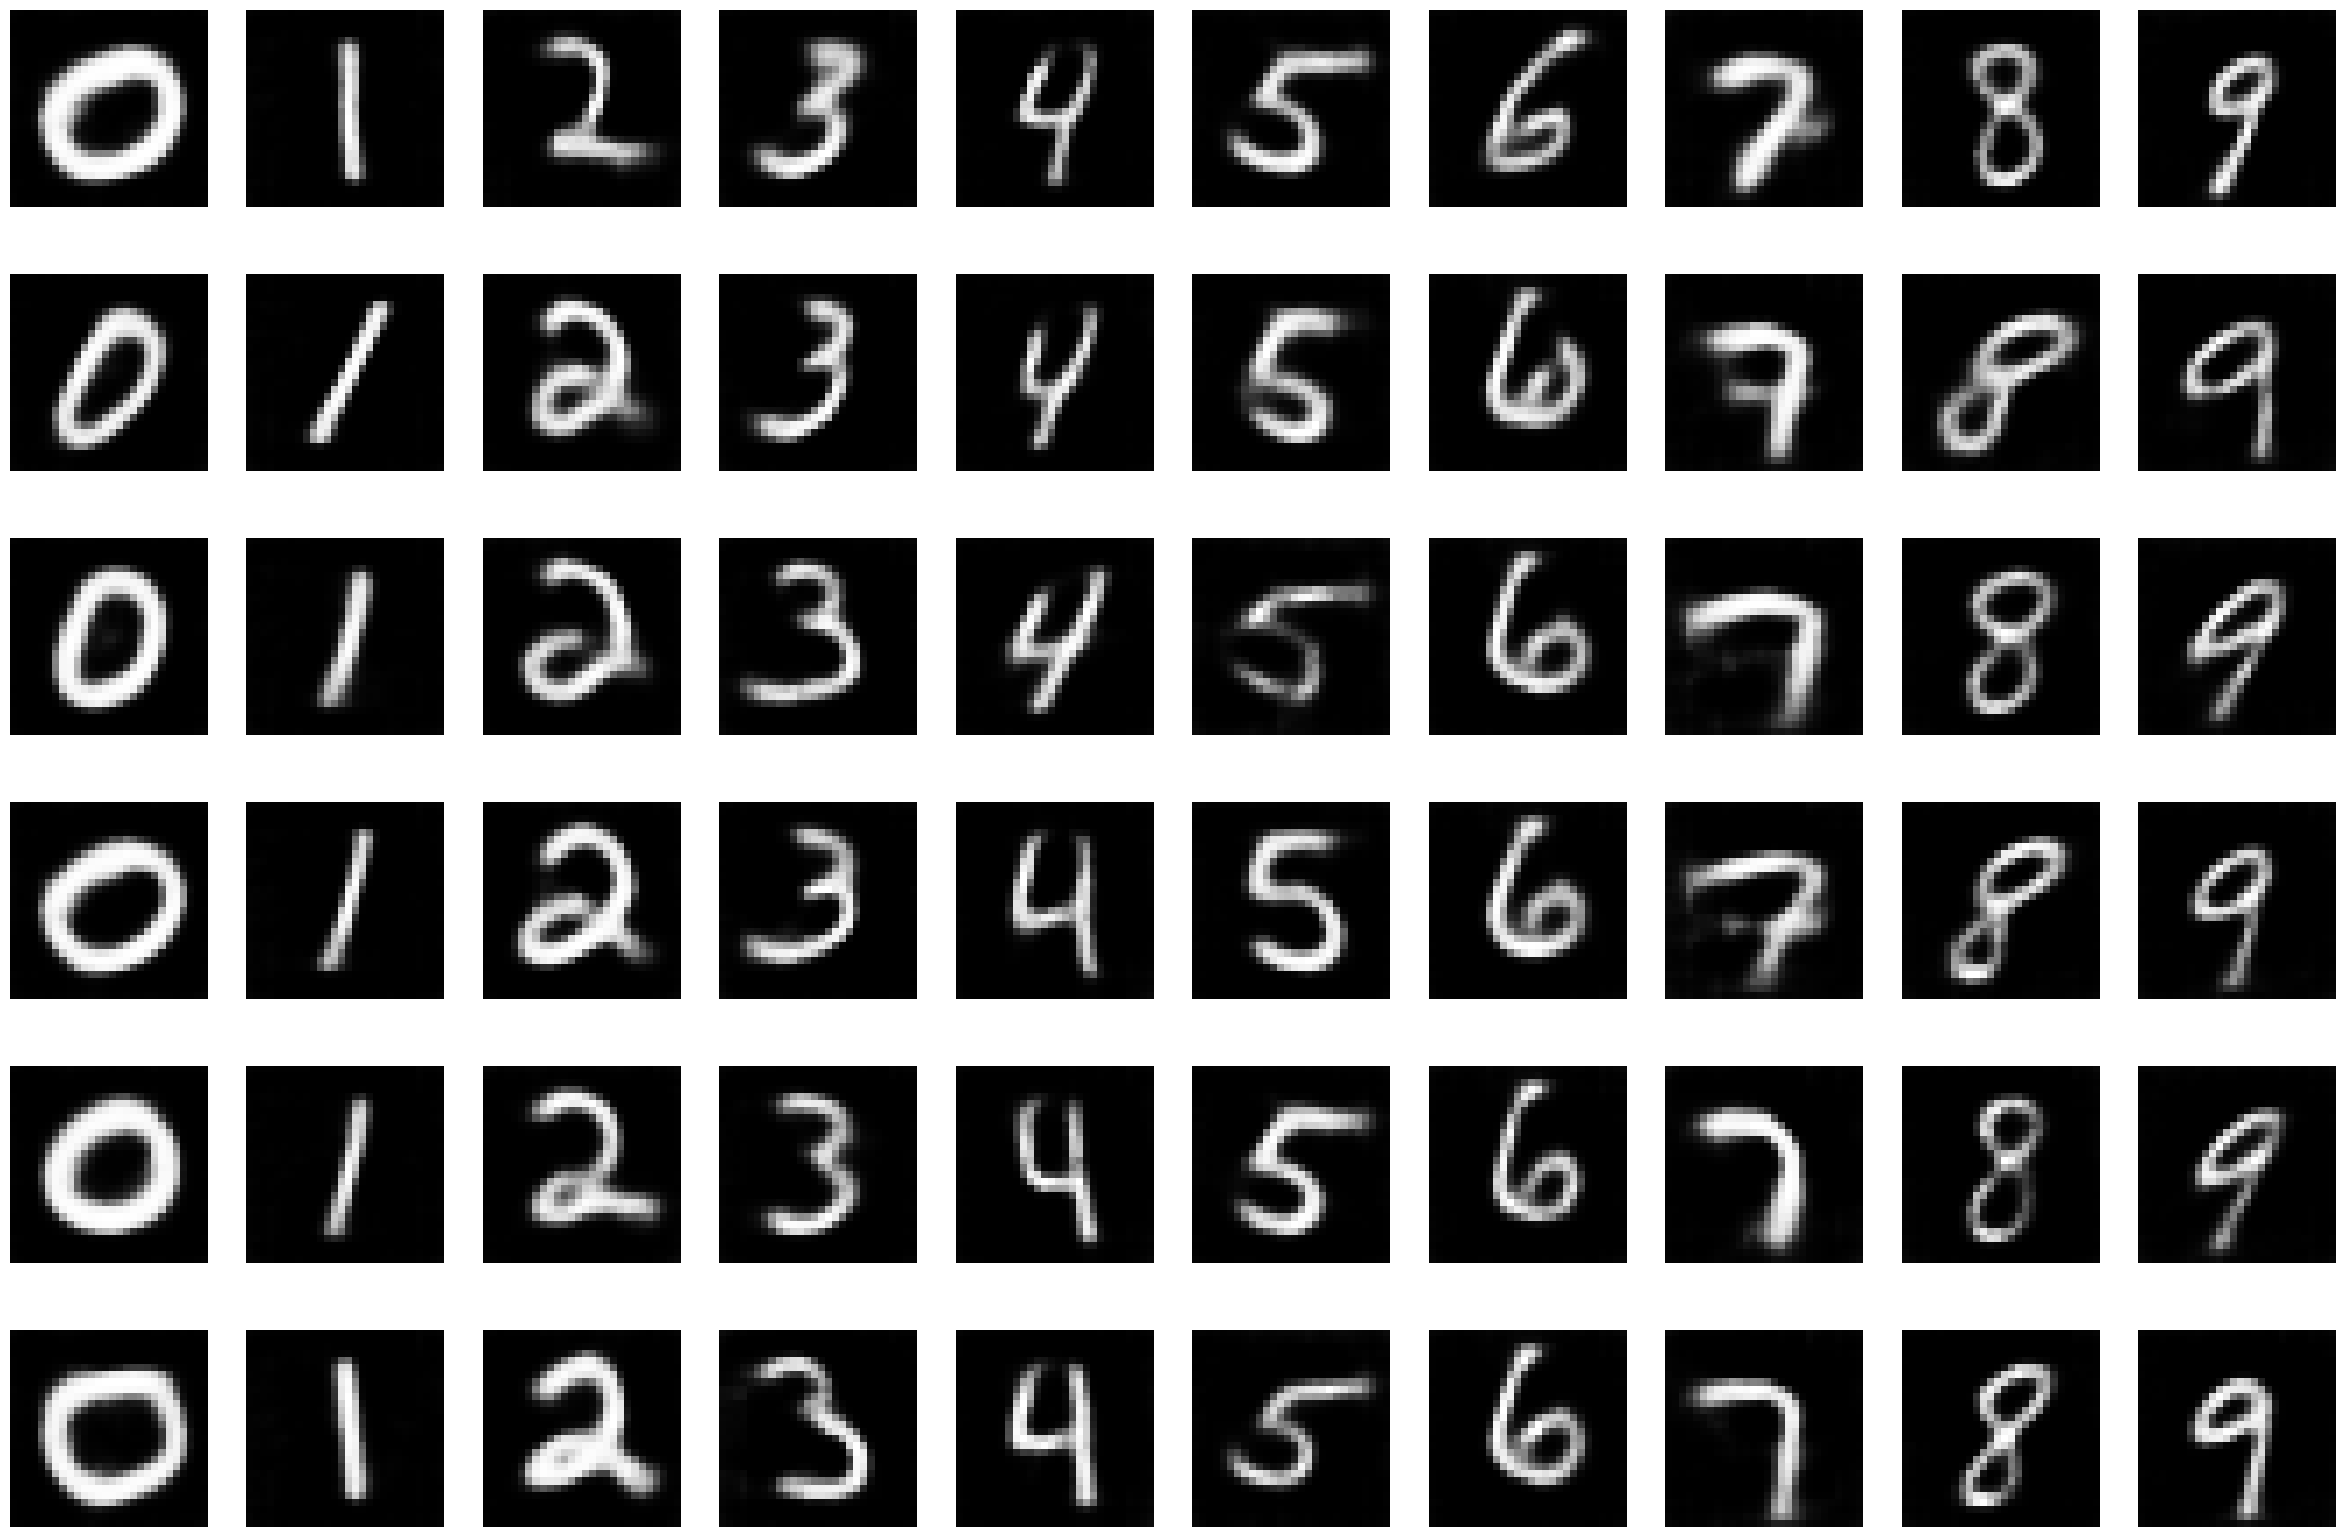

In [ ]:
def test_generate(d):
    noise = torch.randn(d, z_dim).to(device)  # Generate random noise
    model.to(device)
    # Randomly generate class labels as input for AC-GAN
    random_labels = torch.LongTensor([0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9]).to(device)

    # Generate fake images with both noise and labels
    fake = gan.generator(noise, random_labels)

    # Reshape and decode the generated fake images
    reshaped_fake_image = fake.view(d, 64, 1, 1)
    decoded_image = model.decode(reshaped_fake_image)
    decoded_image = decoded_image.cpu().detach().numpy()

    # Plot the decoded images
    plt.figure(figsize=(30, 20))
    for i in range(d):
        plt.subplot(6, 10, i + 1)
        plt.imshow(decoded_image[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Run the function to generate and decode 35 images
test_generate(60)


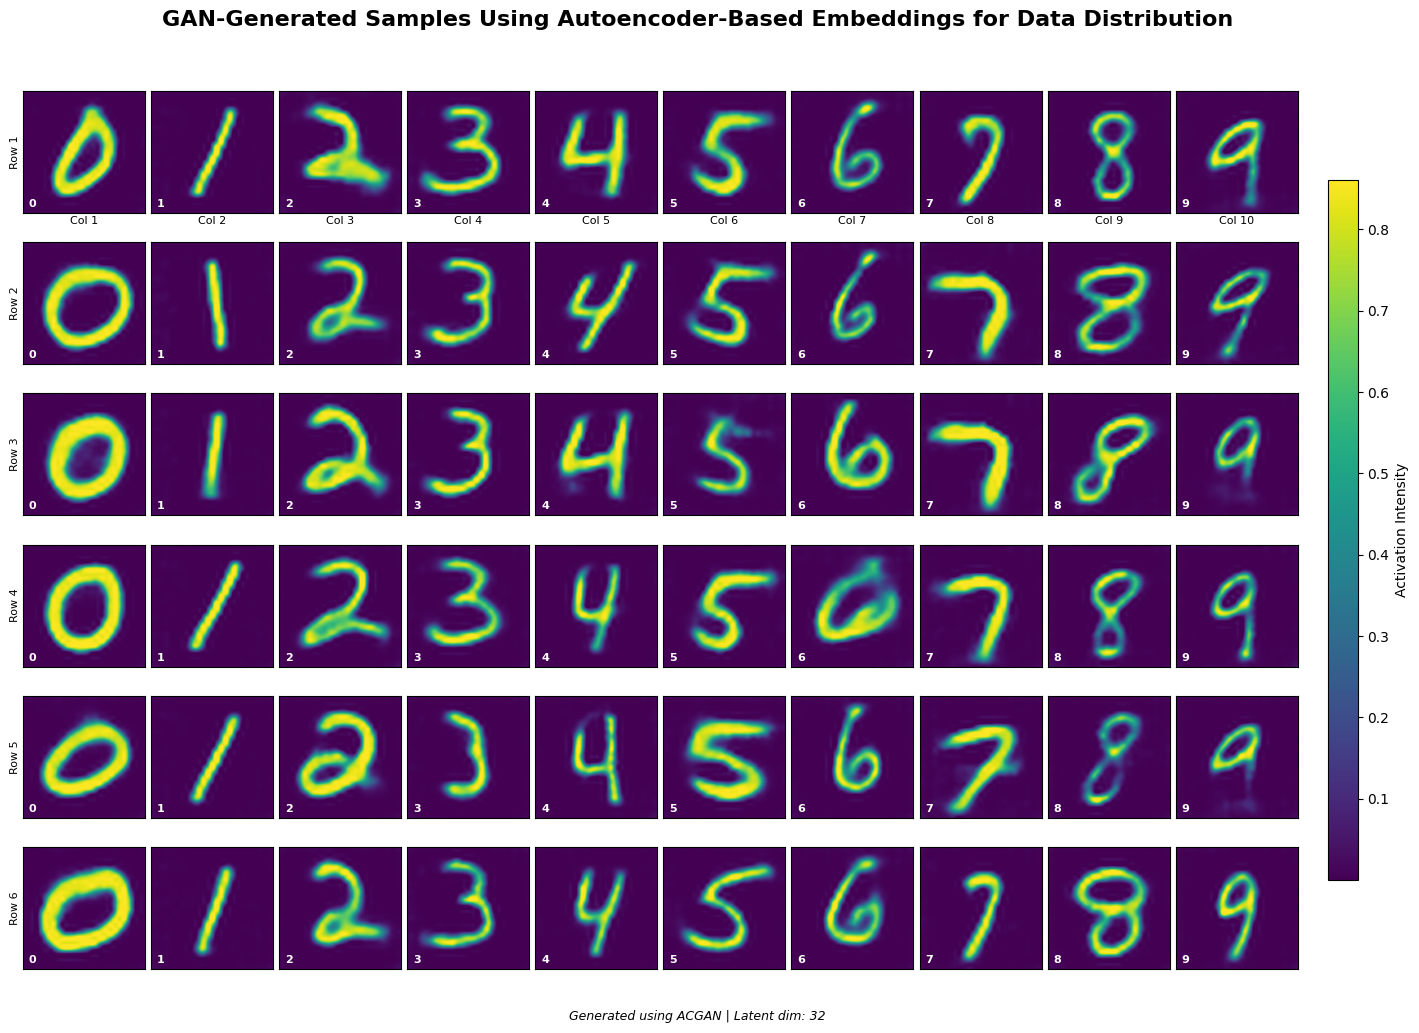

In [ ]:
def test_generate(d):
    # Generate latent vectors and labels
    noise = torch.randn(d, z_dim).to(device)
    random_labels = torch.cat([torch.arange(10) for _ in range(d//10)]).long().to(device)

    # Generate images
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode
        fake = gan.generator(noise, random_labels)
        reshaped_fake = fake.view(d, 64, 1, 1)
        decoded_images = model.decode(reshaped_fake).cpu().numpy()

    # Create figure with better layout
    fig = plt.figure(figsize=(15, 10), dpi=100)
    fig.suptitle('GAN-Generated Samples Using Autoencoder-Based Embeddings for Data Distribution',
                fontsize=16, y=1.02, fontweight='bold')

    # Calculate grid dimensions (6 rows x 10 columns)
    rows = 6
    cols = 10

    for i in range(d):
        ax = fig.add_subplot(rows, cols, i+1)

        # Display image with improved contrast
        img = decoded_images[i].reshape(28, 28)
        im = ax.imshow(img, cmap='viridis', interpolation='lanczos',
                      vmin=img.min(), vmax=img.max())

        # Add class label annotation
        ax.text(0.05, 0.05, str(random_labels[i].item()),
                transform=ax.transAxes,
                color='white' if img.mean() < 0.5 else 'black',
                fontsize=8,
                fontweight='bold')

        # Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # Add column labels for first row
        if i < cols:
            ax.set_xlabel(f'Col {i+1}', fontsize=8, labelpad=2)

        # Add row labels for first column
        if i % cols == 0:
            ax.set_ylabel(f'Row {i//cols+1}', fontsize=8, labelpad=2)

    # Add colorbar
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cax, label='Activation Intensity')

    # Adjust layout and spacing
    plt.subplots_adjust(wspace=0.05, hspace=0.05,
                       left=0.05, right=0.9,
                       bottom=0.05, top=0.95)

    # Add footer text
    plt.figtext(0.5, 0.01,
               f'Generated using ACGAN | Latent dim: {z_dim}',
               ha='center', fontsize=9, style='italic')

    plt.show()

# Generate and display 60 images (6 rows of 10 digits each)
test_generate(60)

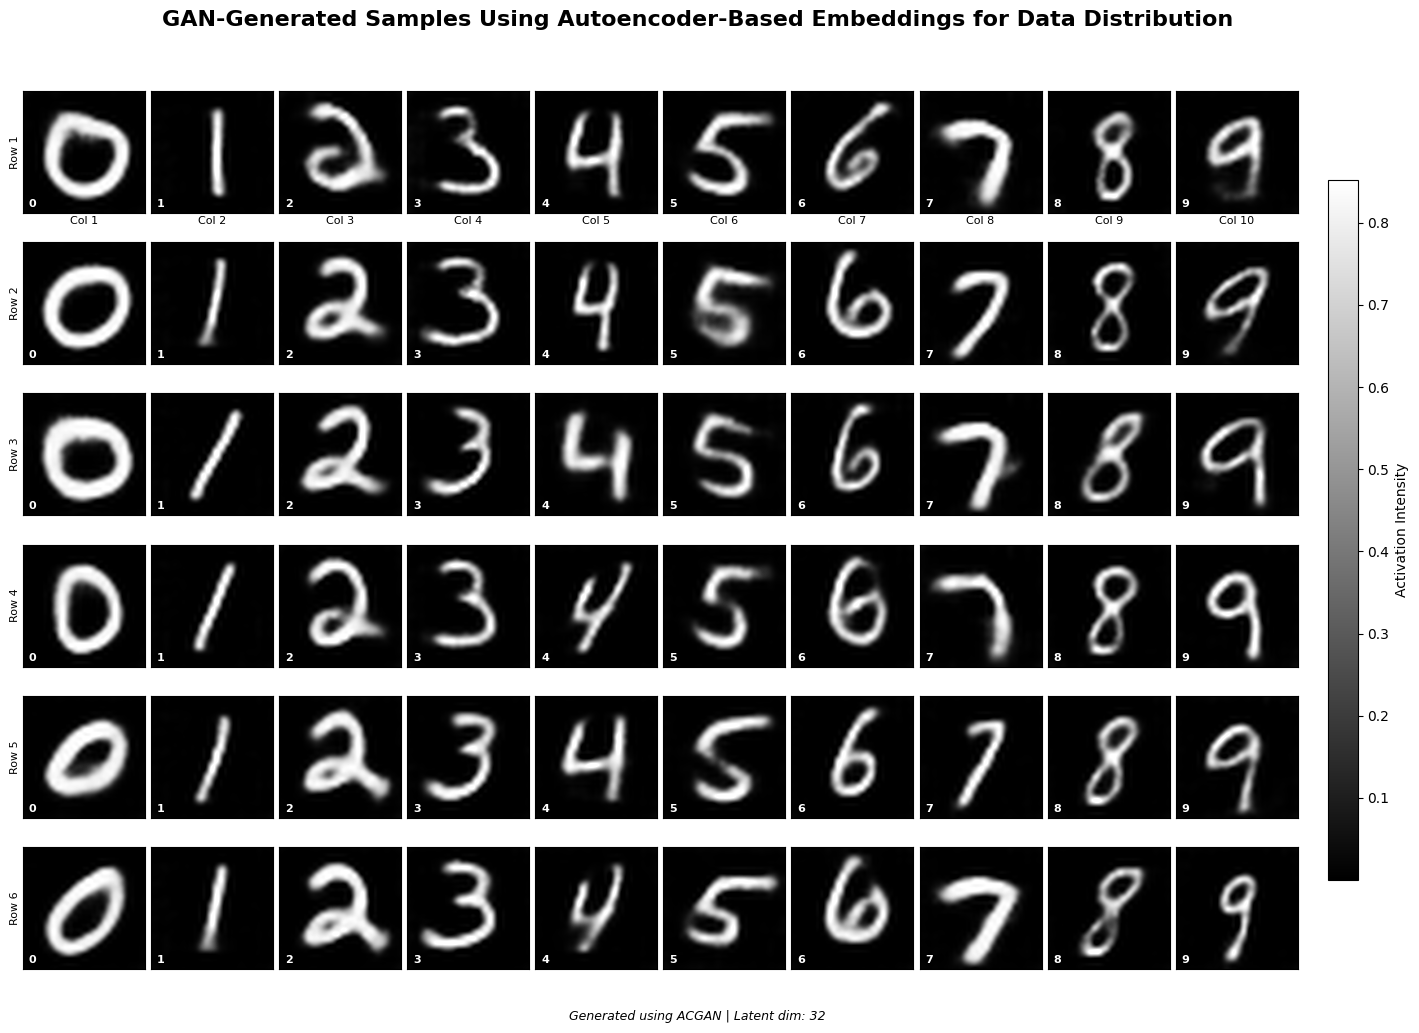

In [ ]:
def test_generate(d):
    # Generate latent vectors and labels
    noise = torch.randn(d, z_dim).to(device)
    random_labels = torch.cat([torch.arange(10) for _ in range(d//10)]).long().to(device)

    # Generate images
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode
        fake = gan.generator(noise, random_labels)
        reshaped_fake = fake.view(d, 64, 1, 1)
        decoded_images = model.decode(reshaped_fake).cpu().numpy()

    # Create figure with better layout
    fig = plt.figure(figsize=(15, 10), dpi=100)
    fig.suptitle('GAN-Generated Samples Using Autoencoder-Based Embeddings for Data Distribution',
                fontsize=16, y=1.02, fontweight='bold')

    # Calculate grid dimensions (6 rows x 10 columns)
    rows = 6
    cols = 10

    for i in range(d):
        ax = fig.add_subplot(rows, cols, i+1)

        # Display image with improved contrast
        img = decoded_images[i].reshape(28, 28)
        im = ax.imshow(img, cmap='gray', interpolation='lanczos',
                      vmin=img.min(), vmax=img.max())

        # Add class label annotation
        ax.text(0.05, 0.05, str(random_labels[i].item()),
                transform=ax.transAxes,
                color='white' if img.mean() < 0.5 else 'black',
                fontsize=8,
                fontweight='bold')

        # Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # Add column labels for first row
        if i < cols:
            ax.set_xlabel(f'Col {i+1}', fontsize=8, labelpad=2)

        # Add row labels for first column
        if i % cols == 0:
            ax.set_ylabel(f'Row {i//cols+1}', fontsize=8, labelpad=2)

    # Add colorbar
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cax, label='Activation Intensity')

    # Adjust layout and spacing
    plt.subplots_adjust(wspace=0.05, hspace=0.05,
                       left=0.05, right=0.9,
                       bottom=0.05, top=0.95)

    # Add footer text
    plt.figtext(0.5, 0.01,
               f'Generated using ACGAN | Latent dim: {z_dim}',
               ha='center', fontsize=9, style='italic')

    plt.show()

# Generate and display 60 images (6 rows of 10 digits each)
test_generate(60)

In [ ]:
# Define the path where you want to save the generator model
model_save_path = '/content/drive/MyDrive/Colab Models/gan_generator.pth'  # You can change this path if you want

# Save the generator model's state_dict
torch.save(gan.generator.state_dict(), model_save_path)

# Confirm that the model has been saved
print(f"Generator model has been successfully saved to {model_save_path}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

class WGAN_Generator(nn.Module):
    def __init__(self, z_dim):
        super(WGAN_Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.Tanh()  # Output should be in the same range as the data
        )

    def forward(self, z):
        return self.model(z)

class WGAN_Critic(nn.Module):
    def __init__(self):
        super(WGAN_Critic, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)  # Output is a scalar value
        )

    def forward(self, x):
        return self.model(x)

class WGAN(nn.Module):
    def __init__(self, z_dim):
        super(WGAN, self).__init__()
        self.generator = WGAN_Generator(z_dim)
        self.critic = WGAN_Critic()

    def forward(self, z):
        generated_data = self.generator(z)
        return self.critic(generated_data)

# Loss and Gradient Penalty
def compute_gradient_penalty(critic, real, fake, device):
    # Randomly sample a point between real and fake data
    epsilon = torch.rand(real.size(0), 1).to(device)
    interpolates = epsilon * real + (1 - epsilon) * fake
    interpolates.requires_grad_(True)

    critic_interpolates = critic(interpolates)

    # Compute the gradients
    gradients = torch.autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(critic_interpolates).to(device),
        create_graph=True,
        retain_graph=True,  # Retain the graph for the next backward pass
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    grad_norm = gradients.norm(2, dim=1)  # L2 norm of the gradients
    gradient_penalty = ((grad_norm - 1) ** 2).mean()  # (||grad||_2 - 1)^2
    return gradient_penalty

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 3e-4  # learning rate
z_dim = 32  # dimension of latent space
batch_size = 32
num_epochs = 50
clip_value = 0.01  # For weight clipping
lambda_gp = 10  # Gradient penalty lambda hyperparameter

# Define WGAN
gan = WGAN(z_dim=z_dim).to(device)
opt_critic = optim.Adam(gan.critic.parameters(), lr=lr, betas=(0.5, 0.999))
opt_gen = optim.Adam(gan.generator.parameters(), lr=lr, betas=(0.5, 0.999))

train_loader = DataLoader(real_vectors_dataset, batch_size=batch_size, shuffle=True)

def train_wgan(num_of_epochs):
    for epoch in range(num_of_epochs):
        for batch_idx, (real_batch, _) in enumerate(train_loader):
            real = real_batch.view(-1, 32).to(device)
            batch_size = real.shape[0]

            # Generate random noise
            noise = torch.randn(batch_size, z_dim).to(device)
            fake = gan.generator(noise)

            # Train Critic (Discriminator)
            for _ in range(5):  # Train Critic more frequently than Generator
                opt_critic.zero_grad()

                # Compute Critic loss
                real_loss = gan.critic(real).mean()
                fake_loss = gan.critic(fake.detach()).mean()
                gp = compute_gradient_penalty(gan.critic, real, fake, device)
                loss_critic = fake_loss - real_loss + lambda_gp * gp

                loss_critic.backward(retain_graph=True)  # Retain the graph for the next backward pass
                opt_critic.step()

                # Clip weights to enforce Lipschitz constraint
                for p in gan.critic.parameters():
                    p.data.clamp_(-clip_value, clip_value)

            # Train Generator
            opt_gen.zero_grad()

            # Compute Generator loss
            loss_generator = -gan.critic(fake).mean()
            loss_generator.backward()
            opt_gen.step()

        print(f"Epoch [{epoch + 1}/{num_of_epochs}] | Loss Critic: {loss_critic.item():.10f}, Loss Generator: {loss_generator.item():.10f}")


NameError: name 'real_vectors_dataset' is not defined

In [ ]:
train_wgan(5)

In [ ]:
class WGANGP_Generator(nn.Module):
    def __init__(self, z_dim):
        super(WGANGP_Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.Tanh()
        )

    def forward(self, noise):
        return self.main(noise)

class WGANGP_Critic(nn.Module):
    def __init__(self):
        super(WGANGP_Critic, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(64, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.main(x)

class WGANGP(nn.Module):
    def __init__(self, z_dim):
        super(WGANGP, self).__init__()
        self.generator = WGANGP_Generator(z_dim)
        self.critic = WGANGP_Critic()

    def forward(self, noise):
        return self.generator(noise)

def compute_gradient_penalty(critic, real_samples, fake_samples, device):
    """Calculates the gradient penalty for WGAN-GP"""
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = critic(interpolates)

    fake = torch.ones(real_samples.size(0), 1).to(device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
z_dim = 32
batch_size = 32
num_epochs = 2
n_critic = 5  # Number of critic iterations per generator iteration
lambda_gp = 10  # Gradient penalty coefficient

wgangp = WGANGP(z_dim).to(device)
opt_gen = optim.Adam(wgangp.generator.parameters(), lr=3e-4, betas=(0.0, 0.9))
opt_critic = optim.Adam(wgangp.critic.parameters(), lr=3e-4, betas=(0.0, 0.9))

train_loader = DataLoader(real_vectors_dataset, batch_size=batch_size, shuffle=True)

def train_WGAN(num_of_epochs):
    for epoch in range(num_of_epochs):
        for batch_idx, (real_batch, _) in enumerate(train_loader):  # Ignore labels
            real = real_batch.view(-1, 64).to(device)
            batch_size = real.size(0)

            # Train Critic (Discriminator equivalent)
            for _ in range(n_critic):
                noise = torch.randn(batch_size, z_dim).to(device)
                fake = wgangp.generator(noise).detach()

                # Compute critic loss
                critic_real = wgangp.critic(real).mean()
                critic_fake = wgangp.critic(fake).mean()

                # Gradient penalty
                gradient_penalty = compute_gradient_penalty(
                    wgangp.critic, real, fake, device
                )

                loss_critic = (critic_fake - critic_real) + lambda_gp * gradient_penalty

                wgangp.critic.zero_grad()
                loss_critic.backward()
                opt_critic.step()

            # Train Generator
            noise = torch.randn(batch_size, z_dim).to(device)
            fake = wgangp.generator(noise)
            loss_gen = -wgangp.critic(fake).mean()

            wgangp.generator.zero_grad()
            loss_gen.backward()
            opt_gen.step()

            # Logging
            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}] | "
                      f"Critic Loss: {loss_critic.item():.4f}, Generator Loss: {loss_gen.item():.4f}")

        print(f"Epoch [{epoch+1}/{num_epochs}] completed")

# Start training
train_WGAN(num_epochs)

Epoch [1/2], Batch [0/1875] | Critic Loss: 7.1404, Generator Loss: -0.0814
Epoch [1/2], Batch [100/1875] | Critic Loss: -4.4412, Generator Loss: -2.8722
Epoch [1/2], Batch [200/1875] | Critic Loss: -3.9684, Generator Loss: -2.8136
Epoch [1/2], Batch [300/1875] | Critic Loss: -3.5157, Generator Loss: -1.5789
Epoch [1/2], Batch [400/1875] | Critic Loss: -3.2113, Generator Loss: -1.5136
Epoch [1/2], Batch [500/1875] | Critic Loss: -3.1606, Generator Loss: -1.3755
Epoch [1/2], Batch [600/1875] | Critic Loss: -2.5956, Generator Loss: -1.2352
Epoch [1/2], Batch [700/1875] | Critic Loss: -2.1576, Generator Loss: -1.4618
Epoch [1/2], Batch [800/1875] | Critic Loss: -2.2764, Generator Loss: -1.1738
Epoch [1/2], Batch [900/1875] | Critic Loss: -2.4865, Generator Loss: -1.1465
Epoch [1/2], Batch [1000/1875] | Critic Loss: -2.4353, Generator Loss: -1.2815
Epoch [1/2], Batch [1100/1875] | Critic Loss: -1.5612, Generator Loss: -0.9617
Epoch [1/2], Batch [1200/1875] | Critic Loss: -2.1338, Generator 

In [ ]:
import matplotlib.pyplot as plt
import torch

def test_generate(d):
    # Generate latent vectors
    noise = torch.randn(d, z_dim).to(device)

    # Generate images
    with torch.no_grad():
        wgangp.eval()  # Set model to evaluation mode
        fake = wgangp.generator(noise)
        reshaped_fake = fake.view(d, 64, 1, 1)
        # Assuming you have a decoder model to map the generated vectors to images
        decoded_images = model.decode(reshaped_fake).cpu().numpy()

    # Create figure with better layout
    fig = plt.figure(figsize=(15, 10), dpi=100)
    fig.suptitle('WGAN-GP Generated Samples',
                fontsize=16, y=1.02, fontweight='bold')

    # Calculate grid dimensions (6 rows x 10 columns)
    rows = 6
    cols = 10

    for i in range(d):
        ax = fig.add_subplot(rows, cols, i+1)

        # Display image with improved contrast
        img = decoded_images[i].reshape(28, 28)
        im = ax.imshow(img, cmap='gray', interpolation='lanczos',
                      vmin=img.min(), vmax=img.max())

        # Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # Add column labels for first row
        if i < cols:
            ax.set_xlabel(f'Col {i+1}', fontsize=8, labelpad=2)

        # Add row labels for first column
        if i % cols == 0:
            ax.set_ylabel(f'Row {i//cols+1}', fontsize=8, labelpad=2)

    # Add colorbar
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cax, label='Activation Intensity')

    # Adjust layout and spacing
    plt.subplots_adjust(wspace=0.05, hspace=0.05,
                       left=0.05, right=0.9,
                       bottom=0.05, top=0.95)

    # Add footer text
    plt.figtext(0.5, 0.01,
               f'Generated using WGAN-GP | Latent dim: {z_dim}',
               ha='center', fontsize=9, style='italic')

    plt.show()

# Generate and display 60 images (6 rows of 10 digits each)
test_generate(60)

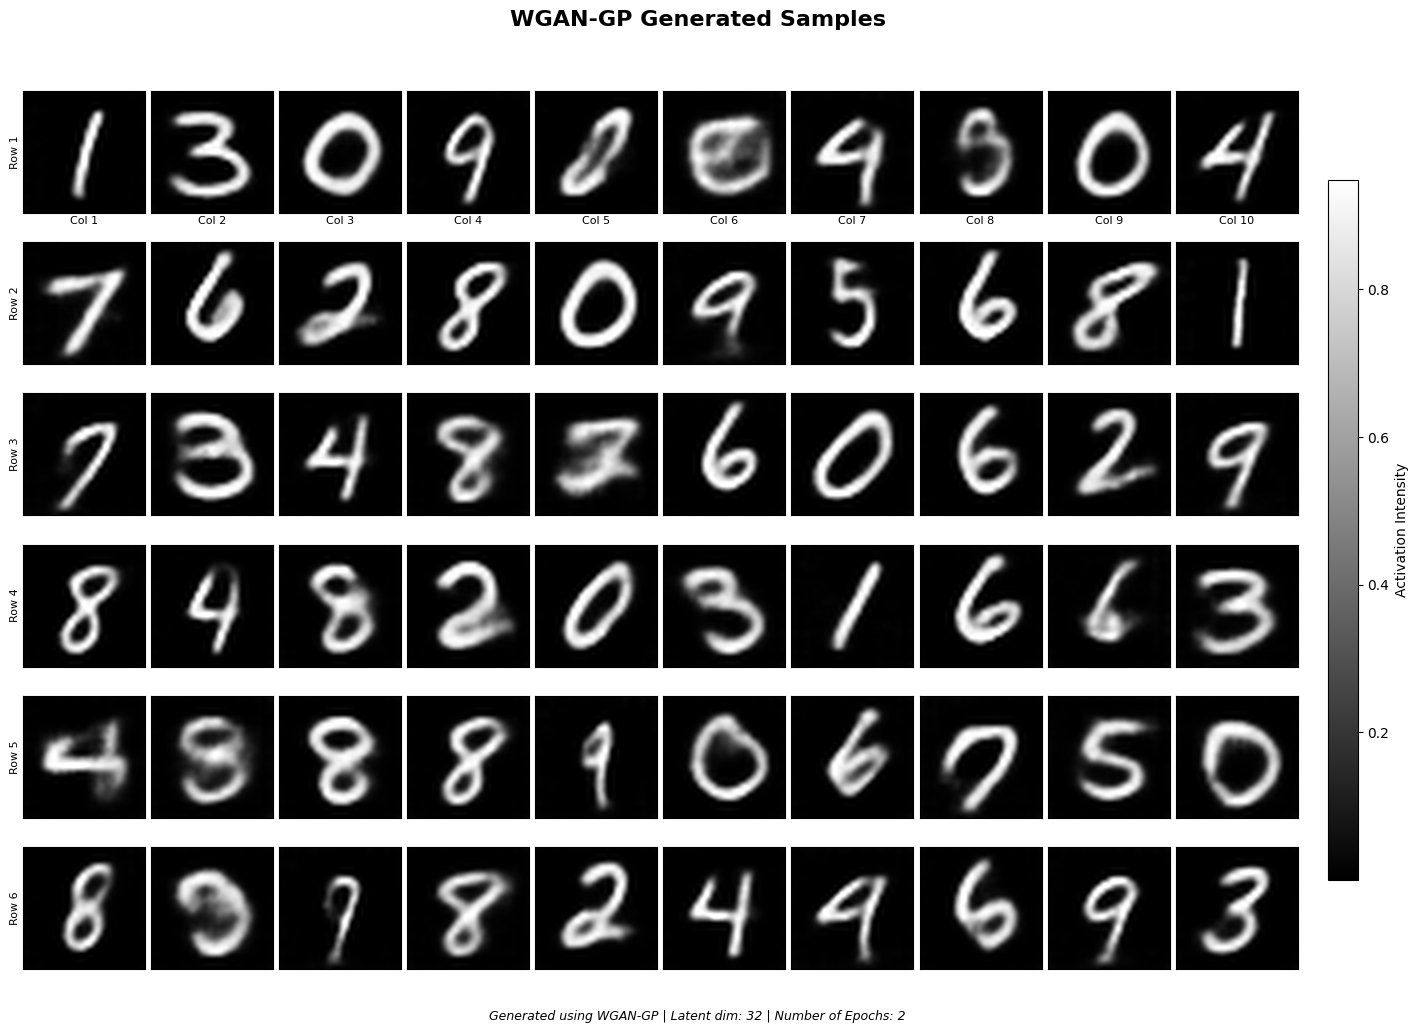

In [ ]:
import matplotlib.pyplot as plt
import torch

def test_generate(d):
    # Generate latent vectors
    noise = torch.randn(d, z_dim).to(device)

    with torch.no_grad():
        wgangp.eval()  # Set generator to evaluation mode
        model.eval()    # Also set decoder model to evaluation mode
        model.to(device)  # Ensure model is on the same device as input
        fake = wgangp.generator(noise)
        reshaped_fake = fake.view(d, 64, 1, 1)
        decoded_images = model.decode(reshaped_fake).cpu().numpy()  # Move to CPU after computation

    # Create figure with better layout
    fig = plt.figure(figsize=(15, 10), dpi=100)
    fig.suptitle('WGAN-GP Generated Samples',
                fontsize=16, y=1.02, fontweight='bold')

    # Calculate grid dimensions (6 rows x 10 columns)
    rows = 6
    cols = 10

    for i in range(d):
        ax = fig.add_subplot(rows, cols, i+1)

        # Display image with improved contrast
        img = decoded_images[i].reshape(28, 28)
        im = ax.imshow(img, cmap='gray', interpolation='lanczos',
                      vmin=img.min(), vmax=img.max())

        # Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # Add column labels for first row
        if i < cols:
            ax.set_xlabel(f'Col {i+1}', fontsize=8, labelpad=2)

        # Add row labels for first column
        if i % cols == 0:
            ax.set_ylabel(f'Row {i//cols+1}', fontsize=8, labelpad=2)

    # Add colorbar
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cax, label='Activation Intensity')

    # Adjust layout and spacing
    plt.subplots_adjust(wspace=0.05, hspace=0.05,
                       left=0.05, right=0.9,
                       bottom=0.05, top=0.95)

    # Add footer text
    plt.figtext(0.5, 0.01,
               f'Generated using WGAN-GP | Latent dim: {z_dim} | Number of Epochs: 2',
               ha='center', fontsize=9, style='italic')

    plt.show()

# Generate and display 60 images (6 rows of 10 digits each)
test_generate(60)

In [ ]:
# Define the path where you want to save the generator model
model_save_path = '/content/drive/MyDrive/Colab Models/wgan_generator_e2.pth'  # You can change this path if you want

# Save the generator model's state_dict
torch.save(wgangp.generator.state_dict(), model_save_path)

# Confirm that the model has been saved
print(f"Generator model has been successfully saved to {model_save_path}")


Generator model has been successfully saved to /content/drive/MyDrive/Colab Models/wgan_generator_e2.pth
